# This notebook is all the code I wrote to convert my datasets into a single csv file for easier training and testing later

From image importing -> saving the feature vectors it is all processed here, other files still do the preprocessing for chosen images but this is for the mass processing of the two dataset folders.

In [ ]:
#Setup
from google.colab import drive
drive.mount('/content/drive')
import os
# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Archie_Short_CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['.DS_Store', 'Personal_Dataset', 'Models', 'CW_Dataset', 'Code', 'test_functions.ipynb']


In [ ]:
#Dependancy Imports
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, ifft2
from skimage import color
from skimage.transform import resize
from skimage.feature import hog

import skimage.feature
import skimage.data as data
from skimage.transform import integral_image

from scipy import ndimage, misc

from scipy.signal import gaussian, convolve2d,wiener
from joblib import dump, load
from PIL import Image
import random
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow 
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
#Import training and testing data

LABEL_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/labels')


def get_train_labels():
  with open(os.path.join(LABEL_FOLDER,'list_label_train.txt'),'r') as f:
    labels = f.readlines()
  f.close()
  labels = [line[16:] for line in labels]
  labels = [line[:1] for line in labels]
  labels = list(map(int, labels))
  return labels

def get_test_labels():
  with open(os.path.join(LABEL_FOLDER,'list_label_test.txt'),'r') as f:
    labels = f.readlines()
  f.close()
  labels = [line[16:] for line in labels]
  labels = [line[:1] for line in labels]
  labels = list(map(int, labels))
  return labels

def get_number(fileName,isTraining):
  if(isTraining):
    trim1 = fileName[5:]
    trim2 = trim1[:4]
  else:
    trim1 = fileName[6:]
    trim2 = trim1[:5]
  cleanId = trim2.lstrip('0')
  return int(cleanId)

TRAIN_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/train')
training_data = []
train_labels = get_train_labels() 

TEST_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/test')
testing_data = []
test_labels = get_train_labels()

print(get_number("train_12270_aligned.jpg",False))

print(get_number("test_3067_aligned.jpg",True))


12270
3067


In [ ]:
#Load in testing and training data 

def create_training_data():
  for img in os.listdir(TRAIN_FOLDER):
    try:
      img_array = cv2.imread(os.path.join(TRAIN_FOLDER,img),cv2.IMREAD_GRAYSCALE)
      training_data.append([img_array,train_labels[get_number(img,False)-1]])
    except Exception as e:
      print(e)
      
def create_test_data():
  for img in os.listdir(TEST_FOLDER):
    try:
      img_array = cv2.imread(os.path.join(TEST_FOLDER,img),cv2.IMREAD_GRAYSCALE)
      testing_data.append([img_array,test_labels[get_number(img,True)-1]])
    except Exception as e:
      print(e)
  
create_training_data()
create_test_data()

invalid literal for int() with base 10: 'ore'
invalid literal for int() with base 10: 'data.'
invalid literal for int() with base 10: 'data_'
invalid literal for int() with base 10: 'data_'


In [ ]:
print(len(training_data))
print(len(testing_data))
print(training_data[3067])

12271
3068
[array([[159, 143, 146, ..., 123, 117, 112],
       [151, 134, 137, ..., 120, 112, 107],
       [140, 123, 131, ..., 123, 114, 107],
       ...,
       [136, 152, 166, ...,  20,  28,  30],
       [184, 159, 120, ...,  21,  30,  32],
       [189, 128,  56, ...,  24,  31,  31]], dtype=uint8), 4]


# Image -> preprocessing -> featurevector pipeline
Converting the image to the right format, equalizing the exposure, smoothing it with wiener then getting the HOG and LBP feature vectors and combining them then returning 


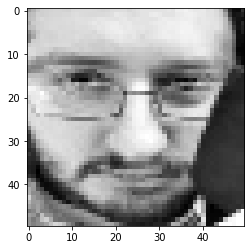

In [ ]:
resized_image = cv2.resize(training_data[9][0], (50, 50)) 
plt.imshow(resized_image,cmap="gray")

**References for the code below**

Implementation of HOG https://www.thepythoncode.com/article/hog-feature-extraction-in-python https://ieeexplore.ieee.org/document/5771368 

Implementation of LBP https://fairyonice.github.io/implement-lbp-from%20scratch.html https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

Wiener Filter smoothing https://www.researchgate.net/figure/Wiener-Filter-implementation-using-Python_fig3_332574579 

Exposure balancing implementation I followed https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html 

4900
3600
70
(70, 70)


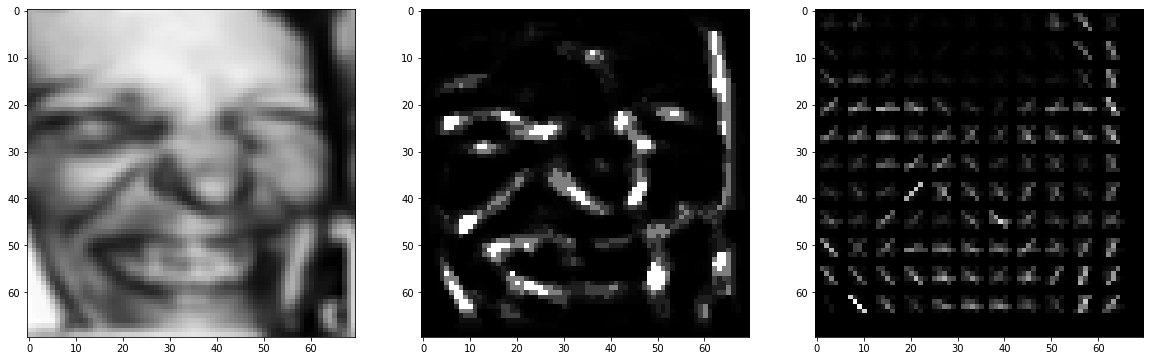

In [ ]:
#reference https://www.researchgate.net/figure/Wiener-Filter-implementation-using-Python_fig3_332574579  

def gaussian_kernal(kernel_size =3):
  h = gaussian(kernel_size,kernel_size/3).reshape(kernel_size,1) 
  h = np.dot(h,h.transpose())
  h /= np.sum(h) 
  return h 

def wiener_filter(img,kernel,k):
  kernel /= np.sum(kernel)
  dummy = np.copy(img)
  dummy = fft2(dummy)
  kernel = fft2(kernel, s=img.shape)
  kernel = np.conj(kernel) / (np.abs(kernel)**2 + k)
  dummy = dummy * kernel
  dummy = np.abs(ifft2(dummy))
  return dummy 


from skimage.feature import local_binary_pattern


def get_feature_vector(img,show):
  #Resize Image
  resized_image = cv2.resize(img, (70, 70)) 

  #reference https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html  

  #Equalise the image exposure
  equalisedImage = cv2.equalizeHist(resized_image)

  #Smooth noise with Wiener
  kernel = gaussian_kernal(4)
  wienerImage = wiener_filter(equalisedImage,kernel,k=5)


  #reference https://fairyonice.github.io/implement-lbp-from%20scratch.html https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

  #Get LBP feature vector
  radius = 5
  n_points = 3 * radius
  lbp = local_binary_pattern(wienerImage, n_points, radius,"ror")
  lbpVector = lbp.ravel()

    #reference https://www.thepythoncode.com/article/hog-feature-extraction-in-python https://ieeexplore.ieee.org/document/5771368 

  #Get HOG feature vector
  if show:
    hogVector,im = hog(equalisedImage, orientations=9, pixels_per_cell=(6,6),cells_per_block=(2, 2), block_norm = "L2",visualize=True,  transform_sqrt=True, feature_vector=True, multichannel=None)
  else:
    hogVector= hog(equalisedImage, orientations=9, pixels_per_cell=(6,6),cells_per_block=(2, 2), block_norm = "L2", transform_sqrt=True, feature_vector=True, multichannel=None)


  if show:
    print(len(lbpVector))
    print(len(hogVector))
    print(len(im))
    f, axarr = plt.subplots(1,3, figsize=(20, 25))
    axarr[0].imshow(wienerImage,cmap="gray")
    axarr[1].imshow(lbp,cmap="gray")
    axarr[2].imshow(im,cmap="gray")
    print(wienerImage.shape)

  

  featureVector = np.concatenate((hogVector,lbpVector))
  return featureVector

test = get_feature_vector(training_data[8956][0],True)
#plt.imshow(training_data[221][0],cmap="gray")


# Writing to a csv file
This is where the data is fed into the feature vector function and saved to the csv files in chunks, I also realised at this point theres really no need to save a csv of the testing data as it isnt used in massive chunks

Here are the references of code I used to create this code https://www.codegrepper.com/code-examples/python/how+to+store+numpy+array+in+csv+file 

https://stackoverflow.com/questions/61445049/pandas-to-csv-writing-keeps-consuming-more-memory-until-it-crashes 

In [ ]:
skip = True
print(training_data[0])
Label_count = [0,0,0,0,0,0,0]
for sample in training_data:
  label = int(sample[1])-1
  Label_count[label] = Label_count[label] +1
 
print(Label_count)

if not skip:
  #writing in chunks
  #reference https://www.codegrepper.com/code-examples/python/how+to+store+numpy+array+in+csv+file 
  #reference https://stackoverflow.com/questions/61445049/pandas-to-csv-writing-keeps-consuming-more-memory-until-it-crashes  
  import pandas as pd 

  chunk_training_data = np.array(testing_data,dtype=object) 
  chunk_training_data = np.array_split(chunk_training_data, 10)


  header = True
  chunkCount = 1
  imageCount = 1
  for chunk in chunk_training_data:
      featureVectorsAndLables = []
      for image,label in chunk:
        fV = get_feature_vector(image,False)
        fV = np.append(fV,[label])
        featureVectorsAndLables.append(fV)
        print("Chunk: ",chunkCount," Countdown: ", len(testing_data)-imageCount)
        imageCount += 1 

      featureVectorsAndLables = np.array(featureVectorsAndLables)
      pd.DataFrame(featureVectorsAndLables).to_csv(os.path.join(TEST_FOLDER,"test_data_refined.csv"),index=False,mode='a',header=header)
      header = False
      chunkCount += 1


[array([[ 20,  19,  19, ...,  13,  14,  15],
       [ 19,  18,  17, ...,  13,  14,  15],
       [ 17,  16,  15, ...,  13,  14,  15],
       ...,
       [114, 112, 101, ..., 100,  91,  85],
       [110, 108,  97, ..., 102,  92,  86],
       [109, 106,  95, ..., 103,  93,  88]], dtype=uint8), 7]
[1290, 281, 717, 4772, 1982, 705, 2524]
Chunk:  1  Countdown:  3067
Chunk:  1  Countdown:  3066
Chunk:  1  Countdown:  3065
Chunk:  1  Countdown:  3064
Chunk:  1  Countdown:  3063
Chunk:  1  Countdown:  3062
Chunk:  1  Countdown:  3061
Chunk:  1  Countdown:  3060
Chunk:  1  Countdown:  3059
Chunk:  1  Countdown:  3058
Chunk:  1  Countdown:  3057
Chunk:  1  Countdown:  3056
Chunk:  1  Countdown:  3055
Chunk:  1  Countdown:  3054
Chunk:  1  Countdown:  3053
Chunk:  1  Countdown:  3052
Chunk:  1  Countdown:  3051
Chunk:  1  Countdown:  3050
Chunk:  1  Countdown:  3049
Chunk:  1  Countdown:  3048
Chunk:  1  Countdown:  3047
Chunk:  1  Countdown:  3046
Chunk:  1  Countdown:  3045
Chunk:  1  Countdown: